First import all neccessary modules

In [1]:
from datetime import datetime
from preprocessor import Preprocessor
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from keras.metrics import Accuracy, Precision, Recall
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from message_encoder import *
from keras.optimizers import Adam, RMSprop, SGD, Nadam
import os
import sys
import tensorflow as tf
tf.config.run_functions_eagerly(True)

Next we define all hyperparameters for the Training of the LSTM module. 

In [2]:
# hyper parameters
# preprocessing
log_files = [i for i in range(745, 754)]            # list of ints representing the numbers of log files to use
logs_per_class = 100                                # How many datapoints per class should be collected if available
window_size = 20                                    # how many log messages to be considered in a single data point from sliding window
encoding_output_size = 16                           # size to be passed to the message_encoder, note that this is not neccessairily the shape of the output
message_encoder = BERTEncoder(encoding_output_size) # the message_encoder to be used. Can be TextVectorizationEncoder (uses keras.layers.TextVectorizer), BERTEncoder (only uses the BERT tokenizer) or BERTEmbeddingEncoder (also uses the BERT model)
extended_datetime_features = False                  # bool, whether the preprocessing should use a multitude of normalized features extracted from the date 
# preprocessor_file = r"C:\Users\Askion\Documents\agmge\log-classification\data\preprocessors\preprocessor_20_smallest_files_100lpc_20ws_BERTencx16.zip" # if this is a string with content, load the file instead of creating a new preprocessor
preprocessor_file = "../data/preprocessors/preprocessor_20_smallest_files_100lpc_20ws_BERTencx16.zip"




Next we load logs and preprocess the data. 

In [3]:
# preprocessing
if os.path.isfile(preprocessor_file):
    print("loading preprocessor from file...")
    pp = Preprocessor.load(preprocessor_file)
else:
    pp = Preprocessor(log_files, 
                    message_encoder, 
                    logs_per_class=logs_per_class, 
                    window_size=window_size, 
                    extended_datetime_features=extended_datetime_features, 
                    volatile=True)
    pp.preprocess()

    # save the dataset if it doesn't exist already!
    path = f"./data/preprocessors/preprocessor_{len(pp.loaded_files)}files_"
    m = "BERTenc" if isinstance(pp.message_encoder, BERTEncoder) else "BERTemb" if isinstance(pp.message_encoder, BERTEmbeddingEncoder) else "TextVec" if isinstance(pp.message_encoder, TextVectorizationEncoder) else "enc"
    path += f"_{logs_per_class}lpc_{window_size}ws_{m}x{encoding_output_size}"
    if extended_datetime_features: path += "_extdt"
    path += ".json"
    if not os.path.isfile(path):
        pp.save(path)


loading preprocessor from file...


In [ ]:
# lstm architecture
lstm_layers = 1                                     # int, how many lstm layers to use
lstm_units_per_layer = 50#10                           # int, how many lstm units per layer to use
dropout = 0.0                                       # float, which dropout value to use, 0.0 is equivalent to not using any dropout
recurrent_dropout = 0.0                             # float, same as with regular dropout

# training
split_ratios = (4, 1)                               # percantage of the collected data that should be used for testing rather than training
epochs = 1000                                       # number of iterations to train
batch_size = 32                                     # int, number of samples processed before updating the model weights.
early_stopping_monitor = "val_loss"                 # what value to monitor for early_stopping. can be 'loss', 'val_loss', 'accuracy', 'val_accuracy', 'precision', 'val_precision', 'recall', 'val_recall', 'f1_score', 'val_f1_score'
early_stopping_patience = 10                        # int, number of epochs to wait after no improvement, if this is greater than epochs, EarlyStopping will not apply
early_stopping_restore_best = True                  # bool, if true keeps the best weights, not the final ones.
validation_split = 0.1
learning_rate = 0.001                               # float to specify learning rate of the optimizer
optimizer = Adam(learning_rate=learning_rate)       # optimizer, can be one of Adam, RMSprop, SGD (can have momentum parameter), Nadam

In [17]:
# defining data for training and testing
train, test = pp.data.stratified_split((4, 1))
X_train, y_train = train
X_test, y_test = test
input_shape = pp.data.entry_shape
num_classes = len(set(y_train))

Define the model architecture for the LSTM, then train the LSTM model. 

In [18]:
# lstm architecture
model = Sequential()
input_shape = pp.data.entry_shape
print(input_shape)
model.add(Input(shape=input_shape))
# First LSTM layer
if lstm_layers > 1:
    model.add(LSTM(lstm_units_per_layer, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout))
else:
    model.add(LSTM(lstm_units_per_layer, dropout=dropout, recurrent_dropout=recurrent_dropout))  # single layer, no sequences returned
# Intermediate LSTM layers (if any)
for i in range(lstm_layers - 2):
    model.add(LSTM(lstm_units_per_layer, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout))
# Last LSTM layer (no return_sequences, output fed into Dense)
if lstm_layers > 1:
    model.add(LSTM(lstm_units_per_layer, dropout=dropout, recurrent_dropout=recurrent_dropout))
# Dense Layer
num_classes = len(set(y_train))
model.add(Dense(num_classes, activation='softmax'))
# compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
# train the model
early_stopping = EarlyStopping(monitor=early_stopping_monitor, 
                               patience=early_stopping_patience, 
                               restore_best_weights=early_stopping_restore_best)
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, callbacks=[early_stopping])


(20, 20)
Epoch 1/1000


d:\mgeo\projects\log-classification\venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.2631 - loss: 1.3777 - val_accuracy: 0.3750 - val_loss: 1.3740
Epoch 2/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.2301 - loss: 1.3742 - val_accuracy: 0.3750 - val_loss: 1.3715
Epoch 3/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.2447 - loss: 1.3717 - val_accuracy: 0.3750 - val_loss: 1.3691
Epoch 4/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.2331 - loss: 1.3699 - val_accuracy: 0.3750 - val_loss: 1.3669
Epoch 5/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.2279 - loss: 1.3665 - val_accuracy: 0.3750 - val_loss: 1.3646
Epoch 6/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.2502 - loss: 1.3671 - val_accuracy: 0.3750 - val_loss: 1.3624
Epoch 7/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 0.2467 - loss: 1.3648 - val_accuracy: 0.3750 - val_loss: 1.3602
Epoch 8/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.2164 - loss: 1.3630 - val_accuracy: 0.3750 - val_lo

Optionally save the weights of the model

In [19]:
# optionally save the model weights
filename = f"../models/lstm_{lstm_layers}x{lstm_units_per_layer}_drop{dropout}_rec{recurrent_dropout}_lr{learning_rate}_bs{batch_size}_ep{epochs}_earlystp{early_stopping_monitor}{early_stopping_patience}{early_stopping_restore_best}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
model.save(f"{filename}.keras")

Evaluate model and print scores

d:\mgeo\projects\log-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\mgeo\projects\log-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\mgeo\projects\log-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

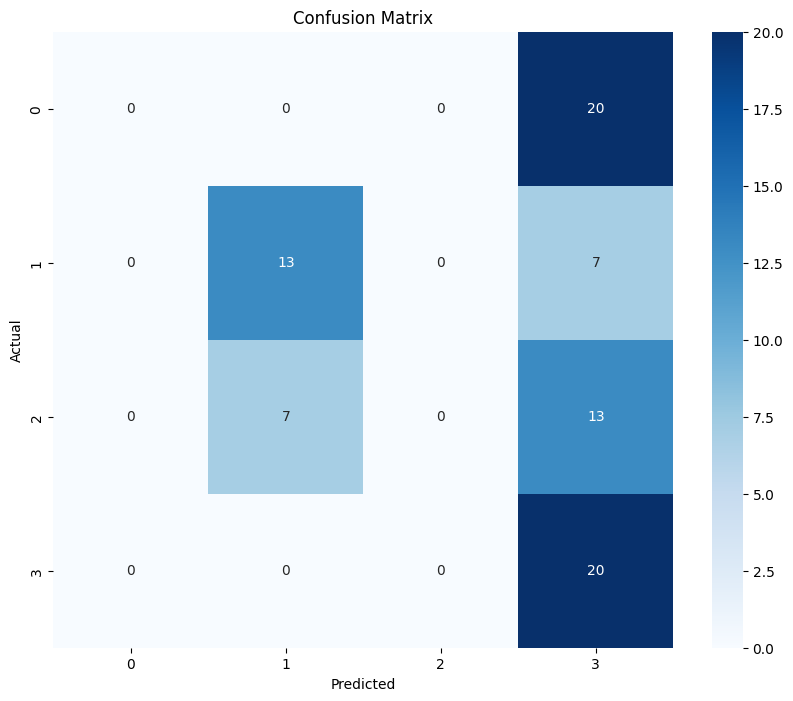

In [20]:
f = open(f"{filename}.txt", "w")
ostd = sys.stdout
sys.stdout = f

# Summary of the model
model.summary(print_fn=f.write)

# Evaluate the model on test data
results = model.evaluate(X_test, y_test, verbose=0)
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

# Predictions
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

# Classification report and F1 score
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score (weighted): {f1:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(f"{filename}.png")
plt.show()


# === Preview Predictions ===
for i in range(min(80, len(y_pred))):
    print(f"True: {y_test[i]}, Pred: {y_pred[i]}, Prob: {predictions[i]}")

sys.stdout = ostd


Save the confusion matrix